# <center>Saint Petersburg's Venues Clustering Project</center>
---
<center>This project is inspired and assembled as a capstone of Data Science courses by IBM and Coursera.</center>

---

<center>Made by: Artem F.</center>
<center>Russia, 2020</center>

<img src="https://i11.fotocdn.net/s117/31ea90a23e063553/public_pin_l/2661415556.jpg" />

## Introduction/Business Problem section

Prior setting for this project is hypothetical restaurateur’s request for market analysis. The well-known restaurateur decided to open a new venue in Saint Petersburg, Russia. It would be obvious suggestion that the most common place for it is the center of the city. But there are several districts in central area. Which one is the best candidate? Area is one of the most major aspect of the site selection as Russian cities are widely spaced along the land. Also, there are too many competitive restaurants may be placed there, so it is important to find the best possible place to get more profit for effective pay back.

The problem of this project is to define better district for opening a new high cuisine restaurant based on points:
1.	Focus on customers with high-income
2.	Total population of districts
3.	Less possible competitive venues along the area
---
## Data section

For this project we will use data:
-	Foursquare data about venues (via Foursquare API)
-	Administrative divisions of Saint Petersburg (parsed directly from Wikipedia with BeautifulSoup4 library)
-	Statistics data of average income from Official Statistics Department of Russia in Saint Petersburg from jan to sept 2018
-	Price of land from Rusland SP
-	Price of land from Restate agency
---
## Preliminary plan of data wrangling is:

1. Gather data from Wikipedia
2. Gather data about venues of Saint Petersburg from Foursquare
3. Buildig basic geodata
4. Visualizing datasourced and merging it into a dataframe
5. Feature selection for clustering and finding a better feature set for neighborhood clustering
6. Model visualisation
---
## Data description:
-	Foursquare API will return data about venues in format listed below. We use following tags for our dataset from the Object:
    - name
    - location
    - categories
    - price
<center>Object example:</center>
<code>
    {'id': '4f3232e219836c91c7bfde94',
    <b>'name': 'Conca Cucina Italian Restaurant',</b>
    <b>'location': {'address': '63 W Broadway',
                 'lat': 40.714484000000006,
                 'lng': -74.00980600000001,
                 'labeledLatLngs': [{'label': 'display',
                 'lat': 40.714484000000006,
                 'lng': -74.00980600000001}],</b>
    'distance': 469,
    'postalCode': '10007',
    'cc': 'US',
    'city': 'New York',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['63 W Broadway',
                         'New York, NY 10007',
                         'United States']},
    <b>'categories': [{'id': '4d4b7105d754a06374d81259',
                          'name': 'Food',
                          'pluralName': 'Food',
                          'shortName': 'Food',
                          'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
                                   'suffix': '.png'},
                                   'primary': True}],</b>
    'referralId': 'v-1588466252',
    'hasPerk': False}
</code>
---

-	<b>Administrative divisions of Saint Petersburg is a teble with the shape 5 x 19 shape with columns:</b>
    - index (int)
    - district name (str)
    - population (int)
    - district size (float)
    - density of population (float)
---

-	<b>Statistics data of average income from Official Statistics Department of Russia in Saint Petersburg from jan to sept 2018 is a xmlx table with the shape 2 x 19 with columns:</b>
    - district name (str)
    - average salary (int)
---

-	<b>Price of land from Rusland SP is a table with the shape 3 x 17 (some districts are missing) with columns:</b>
    - index (int)
    - district name (str)
    - average m^2 landcost (float)
---

-	<b>Price of land from Restate agency is a table set (19 units) with different shapes. Shape of the specific table depends on district's non-living building cost per m^2 with columns:</b>
    - date (date)
    - type of building average m^2 cost (float)
    - type of building average m^2 cost dynamic (float)
---

### Import section

In [155]:
# Basic operations
import pandas as pd
import numpy as np
import requests 
import re
import math

# Geolocation
#!conda install -c conda-forge geopy --yes
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

# Visualisation
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Files processing
import json
from lxml import etree, objectify
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize 

# Model construction
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Lintern
#!pip install pycodestyle pycodestyle_magic
# Usage: add %%pycodestyle in the cell
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Functions section

In [2]:
def html_table_read(html_table, to_erase=None):
    """
    This funtion transform BeautifulSoup tag object with table
    into list of columns. This version removes references from
    column names only.
    TODO: 1. Add references check
    TODO: 2. Refactoring is needed
    
    :param bs4.tag html_table:
    :param list to_erase: [optional] list of symbols which must 
                                     be removed from the results 
                                     (Default = [])
    
    :return: list (Content of the table), 
             list (Content of the column row)
    """
    
    if to_erase is None:
        to_erase = []    
    column_names = []
    table_content = []

    html_rows = html_table.find_all('tr')
    raw_column_names = html_rows[0].find_all('th')

    for element in raw_column_names:
        if element.find('sup') is not None:
            element.sup.decompose()
        name = re.sub("<.*?>", "", str(element))
        column_names.append(name)

    for row in html_rows:
        if row.td is not None:
            current_row = []
            row_elements = row.find_all('td')
            for element in range(0, len(row_elements)):
                value = re.sub("<.*?>", "", str(row_elements[element]))
                for symbol in to_erase:
                    value = value.replace(symbol, "")
                current_row.append(value)
            table_content.append(current_row)
    
    return(table_content, column_names)

In [52]:
def get_nearby_food_venues(names, latitudes, longitudes, radius, prices):
    """
    This function create DataFrame of the venues of the district
    in radius of district's center according to geo coordinates

    :param string names:     District name
    :param float latitudes:  District coordinate X
    :param float longitudes: District coordinate Y
    :param int radius:       Radius of the District Center
    :param list prices:       Price list like [1,2,3,4], where:
                             1 - cheapest ~ 4 - expensive

    :return: pd.DataFrame object
    """
    
    venues_list=[]
    
    for price in prices:
        for name, lat, lng, r in zip(names, latitudes, longitudes, radius):
            
            url = (f'https://api.foursquare.com/v2/venues/explore?&'
                   + f'client_id={CLIENT_ID}&'
                   + f'client_secret={CLIENT_SECRET}&'
                   + f'v={VERSION}&'
                   + f'll={lat},{lng}&'
                   + f'radius={r}&section=food&'
                   + f'limit={LIMIT}&'
                   + f'price={price}&sortByDistance=1')
            
            results = (requests.get(url).json()
                       ["response"]
                       ['groups']
                       [0]
                       ['items'])
            
            print(f'{name} - {price} - {len(results)}')
        
            if len(results) > 0:
                venues_list.append([(name, 
                                     lat, 
                                     lng,
                                     v['venue']['id'],
                                     v['venue']['name'], 
                                     v['venue']['location']['lat'], 
                                     v['venue']['location']['lng'],
                                     v['venue']['location']['distance'],
                                     v['venue']['categories'][0]['name'], 
                                     price) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in 
                                  venues_list for item in 
                                  venue_list])
    
    nearby_venues.columns = ['District', 
                             'District Latitude', 
                             'District Longitude',
                             'Venue ID',
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Distance',
                             'Venue Category',
                             'Price']
    
    return nearby_venues

In [3]:
def transliterate(name):
    """
    Автор: LarsKort
    https://gist.github.com/ledovsky/6398962
    Дата: 16/07/2011; 1:05 GMT-4;
    Не претендую на "хорошесть" словарика. В моем случае и такой пойдет,
    вы всегда сможете добавить свои символы и даже слова. Только
    это нужно делать в обоих списках, иначе будет ошибка.
    """
    
    # Словарь с заменами
    slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
       'ж':'zh','з':'z','и':'i','й':'y','к':'k','л':'l','м':'m','н':'n',
       'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
       'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
       'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
       'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
       'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
       'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
       'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
       '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
       ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
       '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
       'Є':'e', '—':''}
        
    # Циклически заменяем все буквы в строке
    for key in slovar:
        name = name.replace(key, slovar[key])
    return name

In [4]:
def return_most_common_venues(row, num_top_venues):
    """
    This funtion generates
    
    :param string names:     District name
    :param float latitudes:  District coordinate X
    :param float longitudes: District coordinate Y
    :param int radius:       Radius of the Distric Center
    :param list price:       Price list like [1,2,3,4], where:
                             1 - cheapest ~ 4 - expensive
    
    :return: pd.Series object
    """
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    output_row = row_categories_sorted.index.values[0:num_top_venues]
    
    return output_row

### Credentials for Foursquare

In [5]:
with open('credentials.xml') as f:
    xml = f.read()

credentials = objectify.fromstring(xml)

CLIENT_ID = credentials.foursquare.client_id
CLIENT_SECRET = credentials.foursquare.client_secret_key
VERSION = '20200522'
LIMIT = 100 #up to 50 according to Docs, but 100 works too
yandex_api_key = credentials.yandex_maps.api_key

### Get coordinates of Saint Petersburg via converter

In [153]:
geolocator = Nominatim(user_agent="demo")

address = 'Saint Petersburg, Russia'

location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

print('The geographic coordinate of Saint Petersburg are '
      + f'{latitude}, {longitude}.')

The geographic coordinate of Saint Petersburg are 59.9606739, 30.1586551.


### Get districts data of Saint Petersburg from Wikipedia

In [7]:
target_page = ('https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0'
              + '%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%'
              + 'B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%'
              + 'B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B'
              + '8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B'
              + '4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A'
              + '1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%8'
              + '2%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0')
    
response = requests.get(target_page)

In [8]:
with open('spb_districts.html', 'w+b') as f:
    f.write(response.content)
    
with open('spb_districts.html', encoding='UTF-8') as page:
    soup = BeautifulSoup(page, 'lxml')
    
html_table = soup.find('table')

'Table' is a BS4 Tag object. You can referene to:
https://www.crummy.com/software/BeautifulSoup/bs4/doc/#tag

In [10]:
to_drop = [' ', '\t', 
           '\n', '\xa0']

table_content, column_names = html_table_read(html_table, to_drop)

raw_spb_districts_df = pd.DataFrame(table_content, columns=column_names)
raw_spb_districts_df

№              район население,  чел.(2020) площадь, км²  \
0    1     Адмиралтейский                 159795        13,82   
1    2   Василеостровский                 207482        21,47   
2    3         Выборгский                 522746       115,52   
3    4        Калининский                 529187        40,18   
4    5          Кировский                 336157        47,46   
5    6         Колпинский                 193839       102,25   
6    7  Красногвардейский                 356628        56,35   
7    8     Красносельский                 408026        90,49   
8    9      Кронштадтский                  44461        19,53   
9   10          Курортный                  79067       268,19   
10  11         Московский                 352172        73,07   
11  12            Невский                 536137        60,66   
12  13      Петроградский                 128075        19,54   
13  14     Петродворцовый                 143823       107,08   
14  15         Приморский                 573024       109,90   
15  16         Пушкинский                 226336       240,09   
16  17        Фрунзенский                 386537        37,52   
17  18        Центральный                 214572        17,77   

   плотность  населения, чел./км²  
0                         11562,6  
1                          9663,8  
2                          4525,2  
3                         13170,4  
4                            7083  
5                          1895,7  
6                          6328,8  
7                          4509,1  
8                          2276,5  
9                           294,8  
10                         4819,7  
11                         8838,4  
12                         6554,5  
13                         1343,1  
14                           5214  
15                          942,7  
16                        10302,2  
17                          12075

### Collect geo-data of Districts from API Yandex.Maps

In [12]:
district_names = raw_spb_districts_df['район'].to_list()
district_coordinates = []

for name in district_names:
    address = 'Санкт-Петербург, ' + name + ' район'
    target_page = (f'https://geocode-maps.yandex.ru/1.x/?'
                   + f'format=json&apikey={yandex_api_key}&'
                   + f'geocode={address}')
    
    response = requests.get(target_page).json()
    position = (response['response']\
                ['GeoObjectCollection']\
                ['featureMember'][0]\
                ['GeoObject']['Point']\
                ['pos'].split(' '))
    
    lat = position[1]
    lng = position[0]
    location = [name, lat, lng]

    district_coordinates.append(location)

column_names = ['район', 'Latitude', 'Longitude']

geo_spb_districts_df = pd.DataFrame(district_coordinates, 
                                    columns=column_names)
geo_spb_districts_df

район   Latitude  Longitude
0      Адмиралтейский  59.916825  30.297542
1    Василеостровский  59.941425  30.248045
2          Выборгский  60.050448  30.328696
3         Калининский  59.997685  30.396824
4           Кировский  59.876391  30.257603
5          Колпинский  59.775082  30.595792
6   Красногвардейский  59.964458  30.460398
7      Красносельский  59.790793  30.121823
8       Кронштадтский  60.013056  29.714374
9           Курортный  60.181218  29.864878
10         Московский  59.852176  30.323073
11            Невский  59.881932  30.464602
12      Петроградский  59.967687   30.28166
13     Петродворцовый  59.877845  29.866549
14         Приморский  60.017715  30.185145
15         Пушкинский  59.696674  30.421276
16        Фрунзенский  59.869964  30.390788
17        Центральный  59.930908  30.361817

### Merging DF with District data and geodata and rename colmns for better usage

In [13]:
raw_spb_districts_df = raw_spb_districts_df.merge(geo_spb_districts_df)

raw_spb_districts_df.columns = ['DNumber',
                                'District', 
                                'Population', 
                                'Square', 
                                'Density',
                                'Latitude',
                                'Longitude']
raw_spb_districts_df.head()

DNumber          District Population  Square  Density   Latitude  Longitude
0       1    Адмиралтейский     159795   13,82  11562,6  59.916825  30.297542
1       2  Василеостровский     207482   21,47   9663,8  59.941425  30.248045
2       3        Выборгский     522746  115,52   4525,2  60.050448  30.328696
3       4       Калининский     529187   40,18  13170,4  59.997685  30.396824
4       5         Кировский     336157   47,46     7083  59.876391  30.257603

### Now we need to process and clean data

1. Fix incorrect symbols in values to float convertion
2. Convert all Series into appropriate data type

In [14]:
raw_spb_districts_df.Square = (raw_spb_districts_df.copy().Square\
                               .map(lambda x: x.replace(',', '.')))

raw_spb_districts_df.Density = (raw_spb_districts_df.copy().Density\
                                .map(lambda x: x.replace(',', '.')))
raw_spb_districts_df.dtypes

DNumber       object
District      object
Population    object
Square        object
Density       object
Latitude      object
Longitude     object
dtype: object

In [15]:
spb_df = raw_spb_districts_df.copy().astype({'DNumber': 'int32', 
                                             'District': 'string',
                                             'Population': 'int64',
                                             'Square': 'float64',
                                             'Density': 'float32',
                                             'Latitude': 'float32',
                                             'Longitude': 'float64'})
spb_df.dtypes

DNumber         int32
District       string
Population      int64
Square        float64
Density       float32
Latitude      float32
Longitude     float64
dtype: object

In [16]:
spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  
0  30.297542  
1  30.248045  
2  30.328696  
3  30.396824  
4  30.257603

### Let's add average income data and commertial zones rent cost to our dataframe

In [17]:
income_df = pd.read_excel('./data_sources/n_income_stats_09-2018.xlsx')
income_df.head()

Dnumber          District  Income  RentCost
0        1    Адмиралтейский   81481    1408.8
1        2  Василеостровский   71982    4684.6
2        3        Выборгский   64784    1121.1
3        4       Калининский   61920    1065.7
4        5         Кировский   60380    1055.7

In [18]:
spb_df = spb_df.merge(income_df[['Income', 
                                 'RentCost']], 
                      left_index=True, 
                      right_index=True)

if spb_df.RentCost.isna().any() == True:
    mean_cost = spb_df.RentCost.mean()
    nan = spb_df.RentCost.isna()
    
    spb_df.loc[nan,['RentCost']] = mean_cost

spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  Income  RentCost  
0  30.297542   81481    1408.8  
1  30.248045   71982    4684.6  
2  30.328696   64784    1121.1  
3  30.396824   61920    1065.7  
4  30.257603   60380    1055.7

### Add data about cost of square meter of living spaces

In [19]:
flat_cost_df = pd.read_excel('./data_sources/livingCost.xlsx')

flat_cost_df.columns = ['District', 'FlatCostPerM_old',
                        'FlatCostPerM', 'FCChange']

flat_cost_df['FlatCostPerM_old'] = (flat_cost_df['FlatCostPerM_old']\
                                    .map(lambda x: x * 1000))

flat_cost_df['FlatCostPerM'] = (flat_cost_df['FlatCostPerM']\
                                .map(lambda x: x * 1000))

flat_cost_df.head()

District  FlatCostPerM_old  FlatCostPerM  FCChange
0    Адмиралтейский          112900.0      136000.0     0.205
1  Василеостровский          116600.0      110000.0    -0.057
2        Выборгский           88000.0      117000.0     0.330
3       Калининский          101400.0      110000.0     0.085
4         Кировский           88900.0      109500.0     0.232

In [20]:
spb_df = spb_df.merge(flat_cost_df[['FlatCostPerM', 
                                    'FCChange']], 
                      left_index=True, 
                      right_index=True)

spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  Income  RentCost  FlatCostPerM  FCChange  
0  30.297542   81481    1408.8      136000.0     0.205  
1  30.248045   71982    4684.6      110000.0    -0.057  
2  30.328696   64784    1121.1      117000.0     0.330  
3  30.396824   61920    1065.7      110000.0     0.085  
4  30.257603   60380    1055.7      109500.0     0.232

### Creating a map of Saint Petersburg with markers on it

In [21]:
# create map of Saint-Petersburg using latitude and longitude values
map_spb = folium.Map(location=[latitude, longitude], 
                     zoom_start=10)

# add markers to map
for lat, lng, district, population, square in zip(spb_df['Latitude'],
                                                  spb_df['Longitude'],
                                                  spb_df['District'],
                                                  spb_df['Population'],
                                                  spb_df['Square']):
    
    label = transliterate(district) + f' dst., pop: {population}'
    label = folium.Popup(label)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(spb)
    
    folium.Circle(
        [lat, lng],
        radius=((square ** 2) + 6000)).add_to(map_spb)
    
map_spb

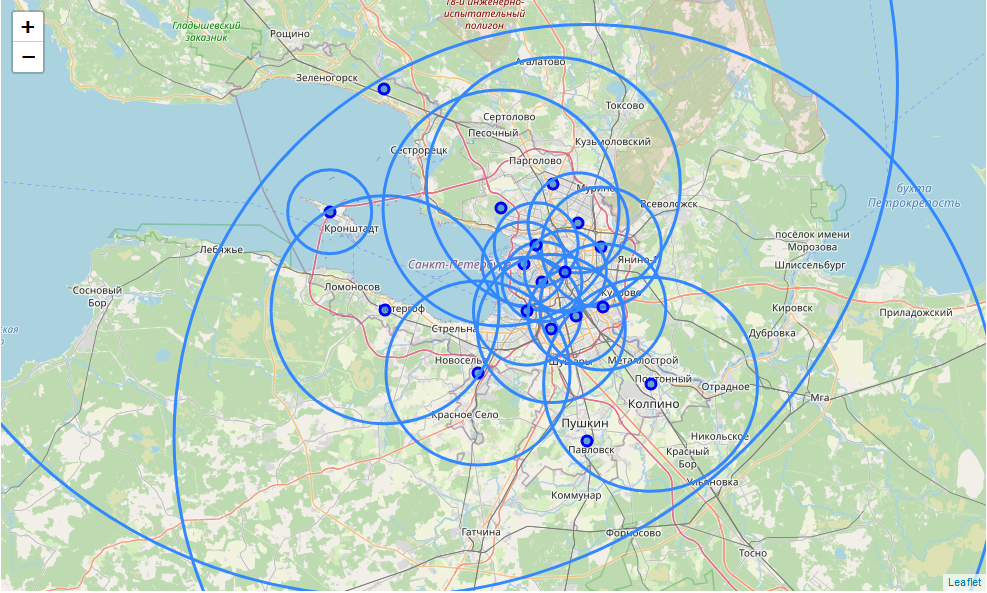

In [144]:
display(Image(filename='./img/raw_radius.PNG'))

It's obviouse that coordinates are correctly displayed on map. We can try to adjust some of the districts. As we'll use Radius param for collecting data about nearest venues so it's crucial data for further data collection.

Notice that: Radiuses of districts outside the center must be bigger
- Some radiuses of the central districts must be smaller and less greedy for space

To solve this problem let's try 3 different approach:
1. Creating Voronoi diagram for searching vertices between districts
2. Use analytical geometry function to determine best possible radius
3. Adjust current values

We'll try example from: https://forum.sources.ru/index.php?showtopic=398331

 (metric - sqrt{(x-x[i])^2+(y-y[i])^2}-R[i], where R[i] -- distance to the nearest center)

### Slice some data for building a Voronoi diagram

In [22]:
spb_points = spb_df[['DNumber', 'Latitude', 'Longitude']]

lat_min = (spb_points.Latitude.min() // 1)
lng_min = (spb_points.Longitude.min() // 1)

spb_points.head()

DNumber   Latitude  Longitude
0        1  59.916824  30.297542
1        2  59.941425  30.248045
2        3  60.050449  30.328696
3        4  59.997684  30.396824
4        5  59.876392  30.257603

### Creating Voronoi diagram for district space segmentation

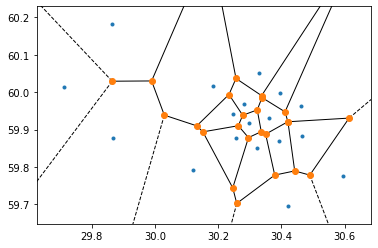

In [23]:
centroids = []

for centroid in range(0, len(spb_points.index)):
    centroids.append([spb_points.iloc[centroid][2], 
                   spb_points.iloc[centroid][1]])

vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor)

plt.show()

vertices = vor.vertices.tolist()

### Calculating nearest vertices for each centroids

In [24]:
nearest_vert_coord = []
    
for i in range(0, len(spb_points.index)):
    closest_point = [0, 0, 0]
    dot_1 = (spb_points.iloc[i][1], 
             spb_points.iloc[i][2])
    
    for j in range(0, len(vertices)):
        dot_2 = (vertices[j][1], 
                 vertices[j][0])
        dist = geodesic(dot_1, 
                        dot_2).m
        
        if dist > 0 and ((closest_point[2] == 0) or 
                         (closest_point[2] >= dist)):
            closest_point = [vertices[j][1], 
                             vertices[j][0], 
                             dist]
    
    nearest_vert_coord.append(closest_point)

closest_vert_df = pd.DataFrame(nearest_vert_coord, 
                               columns=['ClosestVertLat', 
                                        'ClosestVertLng', 
                                        'VertDist'])

spb_points = spb_points.merge(closest_vert_df, 
                              left_index=True, 
                              right_index=True)
spb_points.head()

DNumber   Latitude  Longitude  ClosestVertLat  ClosestVertLng     VertDist
0        1  59.916824  30.297542       59.910482       30.263528  2029.900654
1        2  59.941425  30.248045       59.938455       30.277431  1675.697735
2        3  60.050449  30.328696       60.036852       30.256289  4310.003781
3        4  59.997684  30.396824       59.990929       30.337095  3417.388347
4        5  59.876392  30.257603       59.878723       30.295678  2148.209815

### Calculating nearest District for better radius value

In [25]:
nearest_dist_coord = []
centroids_num = len(spb_points.index)

for district_a in range(0, centroids_num):
    closest_point = [0, 0, 0, 0]
    lat_a = spb_points.iloc[district_a][1]
    lng_a = spb_points.iloc[district_a][2]
    
    dot_1 = (lat_a, lng_a)
    
    for district_b in range(0, centroids_num):
        lat_b = spb_points.iloc[district_b][1]
        lng_b = spb_points.iloc[district_b][2]
        
        dot_2 = (lat_b, lng_b)
        
        dist = geodesic(dot_1, dot_2).m
        
        if dist > 0 and ((closest_point[2] == 0) or 
                         (closest_point[2] >= dist)):
            closest_district_num = int(spb_points.iloc[district_b][0])
            
            closest_point = [spb_points.iloc[district_b][1],
                             spb_points.iloc[district_b][2], 
                             dist, 
                             closest_district_num]
    
    nearest_dist_coord.append(closest_point)

closest_df = pd.DataFrame(nearest_dist_coord, 
                          columns=['ClosestDstLat', 
                                   'ClosestDstLng', 
                                   'Dist', 
                                   'ClosestDNumber'])

spb_points = spb_points.merge(closest_df, 
                              left_index=True, 
                              right_index=True)
spb_points.head()

DNumber   Latitude  Longitude  ClosestVertLat  ClosestVertLng     VertDist  \
0        1  59.916824  30.297542       59.910482       30.263528  2029.900654   
1        2  59.941425  30.248045       59.938455       30.277431  1675.697735   
2        3  60.050449  30.328696       60.036852       30.256289  4310.003781   
3        4  59.997684  30.396824       59.990929       30.337095  3417.388347   
4        5  59.876392  30.257603       59.878723       30.295678  2148.209815   

   ClosestDstLat  ClosestDstLng         Dist  ClosestDNumber  
0      59.941425      30.248045  3895.257682               2  
1      59.967686      30.281660  3476.742378              13  
2      59.997684      30.396824  6999.256538               4  
3      59.964458      30.460398  5128.525294               7  
4      59.852177      30.323073  4553.464083              11

Now we have dataframe with data of coordinates and distance between each District center and:
1. Closest District
2. Closest vertice of Voronoi diagram

In [26]:
r2 = []

for centroid in range(0, len(spb_points)):
    
    x = geodesic((spb_points.iloc[centroid][1], 0),
                 (spb_points.iloc[centroid][6], 0)).m
    
    y = geodesic((0, spb_points.iloc[centroid][2]),
                 (0, spb_points.iloc[centroid][7])).m
    
    dist = spb_points.iloc[centroid][8]
    
    radius = math.sqrt(x ** 2 + y ** 2) - dist
    
    r2.append(radius)

r2[:5]

[2258.764952224075,
 1273.243717275483,
 2596.343075982575,
 2858.177944190935,
 3217.9397634220686]

In [27]:
r_function = pd.Series(r2)

copy_spb_df = spb_df.copy()

if 'R1' in copy_spb_df.columns:
    copy_spb_df.drop(axis=1, 
                     columns='R1', 
                     inplace=True)
    
if 'R2' in copy_spb_df.columns:
    copy_spb_df.drop(axis=1, 
                     columns='R2', 
                     inplace=True)

copy_spb_df.insert(loc=len(copy_spb_df.columns), 
                   column='R1', 
                   value=spb_points.VertDist)

copy_spb_df.insert(loc=len(copy_spb_df.columns), 
                   column='R2', 
                   value=r_function)

In [28]:
copy_spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  Income  RentCost  FlatCostPerM  FCChange           R1  \
0  30.297542   81481    1408.8      136000.0     0.205  2029.900654   
1  30.248045   71982    4684.6      110000.0    -0.057  1675.697735   
2  30.328696   64784    1121.1      117000.0     0.330  4310.003781   
3  30.396824   61920    1065.7      110000.0     0.085  3417.388347   
4  30.257603   60380    1055.7      109500.0     0.232  2148.209815   

            R2  
0  2258.764952  
1  1273.243717  
2  2596.343076  
3  2858.177944  
4  3217.939763

### Adding Radius values to DataFrame

In [29]:
copy_spb_df['R3'] = ((copy_spb_df.Square ** 2) + 6000)
copy_spb_df['R4'] = (copy_spb_df['R2'] + copy_spb_df['R1']) / 2
copy_spb_df['R'] = (copy_spb_df['R4'] + copy_spb_df['R3']) / 2
copy_spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  Income  RentCost  FlatCostPerM  FCChange           R1  \
0  30.297542   81481    1408.8      136000.0     0.205  2029.900654   
1  30.248045   71982    4684.6      110000.0    -0.057  1675.697735   
2  30.328696   64784    1121.1      117000.0     0.330  4310.003781   
3  30.396824   61920    1065.7      110000.0     0.085  3417.388347   
4  30.257603   60380    1055.7      109500.0     0.232  2148.209815   

            R2          R3           R4             R  
0  2258.764952   6190.9924  2144.332803   4167.662601  
1  1273.243717   6460.9609  1474.470726   3967.715813  
2  2596.343076  19344.8704  3453.173428  11399.021914  
3  2858.177944   7614.4324  3137.783146   5376.107773  
4  3217.939763   8252.4516  2683.074789   5467.763195

### Fixing too big radius values

In [47]:
r_max = 12000
wrong_r = (copy_spb_df['R'] > r_max)

copy_spb_df.loc[wrong_r, ['R']] = r_max
copy_spb_df.head(10)

DNumber           District  Population  Square       Density   Latitude  \
0         1     Адмиралтейский      159795   13.82  11562.599609  59.916824   
1         2   Василеостровский      207482   21.47   9663.799805  59.941425   
2         3         Выборгский      522746  115.52   4525.200195  60.050449   
3         4        Калининский      529187   40.18  13170.400391  59.997684   
4         5          Кировский      336157   47.46   7083.000000  59.876392   
5         6         Колпинский      193839  102.25   1895.699951  59.775082   
6         7  Красногвардейский      356628   56.35   6328.799805  59.964458   
7         8     Красносельский      408026   90.49   4509.100098  59.790794   
8         9      Кронштадтский       44461   19.53   2276.500000  60.013058   
9        10          Курортный       79067  268.19    294.799988  60.181217   
10       11         Московский      352172   73.07   4819.700195  59.852177   
11       12            Невский      536137   60.66   8838.400391  59.881931   
12       13      Петроградский      128075   19.54   6554.500000  59.967686   
13       14     Петродворцовый      143823  107.08   1343.099976  59.877846   
14       15         Приморский      573024  109.90   5214.000000  60.017715   
15       16         Пушкинский      226336  240.09    942.700012  59.696674   
16       17        Фрунзенский      386537   37.52  10302.200195  59.869965   
17       18        Центральный      214572   17.77  12075.000000  59.930908   

    Longitude  Income     RentCost  FlatCostPerM  FCChange            R1  \
0   30.297542   81481  1408.800000      136000.0     0.205   2029.900654   
1   30.248045   71982  4684.600000      110000.0    -0.057   1675.697735   
2   30.328696   64784  1121.100000      117000.0     0.330   4310.003781   
3   30.396824   61920  1065.700000      110000.0     0.085   3417.388347   
4   30.257603   60380  1055.700000      109500.0     0.232   2148.209815   
5   30.595792   55949   315.500000       65500.0     0.006   5987.471280   
6   30.460398   59378  1011.600000       94200.0     0.135   3331.249484   
7   30.121823   55923  1436.200000      111000.0     0.164   8685.956935   
8   29.714374   51136  1412.876471      103900.0     0.572   8606.694318   
9   29.864878   62644   600.300000       74000.0    -0.209  16900.267268   
10  30.323073   73386  1363.100000      114300.0    -0.031   3332.074000   
11  30.464602   56042  1273.100000      106700.0     0.204   5011.788378   
12  30.281660   89752  1664.300000      193500.0     0.094   2859.419101   
13  29.866549   56741   814.400000       73300.0     0.049  11380.375866   
14  30.185145   65833  1296.300000      111200.0     0.087   3800.790577   
15  30.421276   58602  1193.700000       82200.0    -0.121   9180.696386   
16  30.390788   56098  1362.500000      127800.0     0.128   3038.144893   
17  30.361817   76728  2352.000000      176700.0     0.117   3251.033728   

              R2          R3            R4             R  
0    2258.764952   6190.9924   2144.332803   4167.662601  
1    1273.243717   6460.9609   1474.470726   3967.715813  
2    2596.343076  19344.8704   3453.173428  11399.021914  
3    2858.177944   7614.4324   3137.783146   5376.107773  
4    3217.939763   8252.4516   2683.074789   5467.763195  
5    8161.002855  16455.0625   7074.237067  11764.649784  
6    2858.177944   9175.3225   3094.713714   6135.018107  
7    5668.454147  14188.4401   7177.205541  10682.822820  
8    5369.829404   6381.4209   6988.261861   6684.841381  
9    4612.457059  77925.8761  10756.362164  12000.000000  
10   3513.464855  11339.2249   3422.769427   7380.997164  
11   3980.508850   9679.6356   4496.148614   7087.892107  
12   1273.243717   6381.8116   2066.331409   4224.071505  
13  12735.046792  17466.1264  12057.711329  12000.000000  
14   4352.331687  18078.0100   4076.561132  11077.285566  
15   8161.002855  63643.2081   8670.849620  12000.000000  
16   3513.464855   7407.7504   3275.804874   5341.7776

In [129]:
copy_spb_df.head(10)

DNumber           District  Population  Square       Density   Latitude  \
0        1     Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2   Василеостровский      207482   21.47   9663.799805  59.941425   
2        3         Выборгский      522746  115.52   4525.200195  60.050449   
3        4        Калининский      529187   40.18  13170.400391  59.997684   
4        5          Кировский      336157   47.46   7083.000000  59.876392   
5        6         Колпинский      193839  102.25   1895.699951  59.775082   
6        7  Красногвардейский      356628   56.35   6328.799805  59.964458   
7        8     Красносельский      408026   90.49   4509.100098  59.790794   
8        9      Кронштадтский       44461   19.53   2276.500000  60.013058   
9       10          Курортный       79067  268.19    294.799988  60.181217   

   Longitude  Income     RentCost  FlatCostPerM  FCChange            R1  \
0  30.297542   81481  1408.800000      136000.0     0.205   2029.900654   
1  30.248045   71982  4684.600000      110000.0    -0.057   1675.697735   
2  30.328696   64784  1121.100000      117000.0     0.330   4310.003781   
3  30.396824   61920  1065.700000      110000.0     0.085   3417.388347   
4  30.257603   60380  1055.700000      109500.0     0.232   2148.209815   
5  30.595792   55949   315.500000       65500.0     0.006   5987.471280   
6  30.460398   59378  1011.600000       94200.0     0.135   3331.249484   
7  30.121823   55923  1436.200000      111000.0     0.164   8685.956935   
8  29.714374   51136  1412.876471      103900.0     0.572   8606.694318   
9  29.864878   62644   600.300000       74000.0    -0.209  16900.267268   

            R2          R3            R4             R  
0  2258.764952   6190.9924   2144.332803   4167.662601  
1  1273.243717   6460.9609   1474.470726   3967.715813  
2  2596.343076  19344.8704   3453.173428  11399.021914  
3  2858.177944   7614.4324   3137.783146   5376.107773  
4  3217.939763   8252.4516   2683.074789   5467.763195  
5  8161.002855  16455.0625   7074.237067  11764.649784  
6  2858.177944   9175.3225   3094.713714   6135.018107  
7  5668.454147  14188.4401   7177.205541  10682.822820  
8  5369.829404   6381.4209   6988.261861   6684.841381  
9  4612.457059  77925.8761  10756.362164  12000.000000

### Let's make quick review of new Radius values

In [130]:
map_spb = folium.Map(location=[latitude, longitude], zoom_start=10)

for dn, lat, lng, district, population, rad in zip(copy_spb_df['DNumber'],
                                                   copy_spb_df['Latitude'], 
                                                   copy_spb_df['Longitude'],
                                                   copy_spb_df['District'],
                                                   copy_spb_df['Population'],
                                                   copy_spb_df['R']):
    
    label = f'{dn}, {transliterate(district)} dst., pop: {population}, R = {round(rad)} m.'
    label = folium.Popup(label)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)
    
    folium.Circle([lat, lng],
                    radius=rad
                   ).add_to(map_spb)
    
map_spb

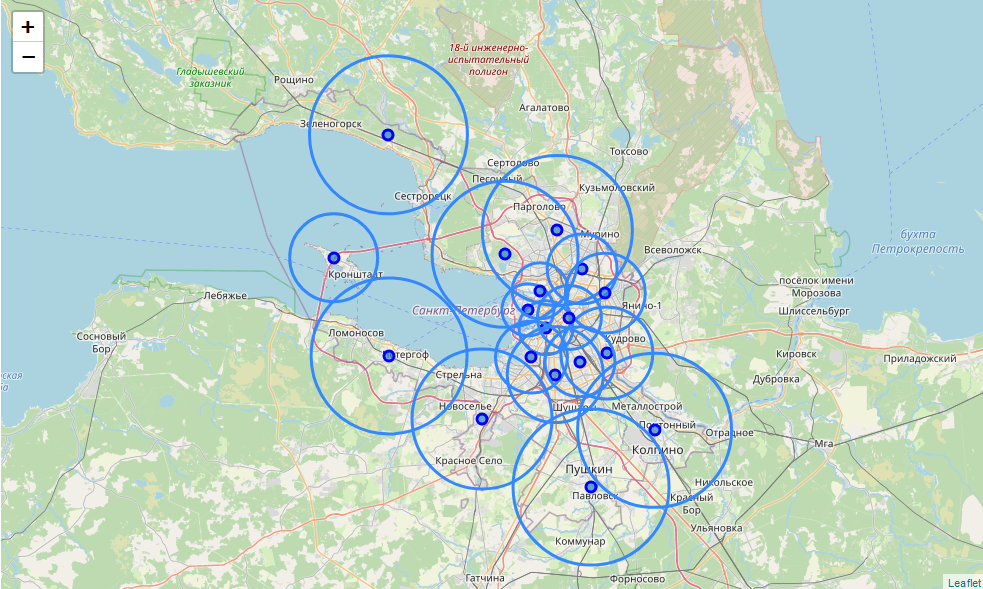

In [145]:
display(Image(filename='./img/raw_radius_0.PNG'))

### Collecting data about venues in Saint-Petersburg

In [49]:
spb_df = copy_spb_df
spb_df.head()

DNumber          District  Population  Square       Density   Latitude  \
0        1    Адмиралтейский      159795   13.82  11562.599609  59.916824   
1        2  Василеостровский      207482   21.47   9663.799805  59.941425   
2        3        Выборгский      522746  115.52   4525.200195  60.050449   
3        4       Калининский      529187   40.18  13170.400391  59.997684   
4        5         Кировский      336157   47.46   7083.000000  59.876392   

   Longitude  Income  RentCost  FlatCostPerM  FCChange           R1  \
0  30.297542   81481    1408.8      136000.0     0.205  2029.900654   
1  30.248045   71982    4684.6      110000.0    -0.057  1675.697735   
2  30.328696   64784    1121.1      117000.0     0.330  4310.003781   
3  30.396824   61920    1065.7      110000.0     0.085  3417.388347   
4  30.257603   60380    1055.7      109500.0     0.232  2148.209815   

            R2          R3           R4             R  
0  2258.764952   6190.9924  2144.332803   4167.662601  
1  1273.243717   6460.9609  1474.470726   3967.715813  
2  2596.343076  19344.8704  3453.173428  11399.021914  
3  2858.177944   7614.4324  3137.783146   5376.107773  
4  3217.939763   8252.4516  2683.074789   5467.763195

In [53]:
spb_venues = get_nearby_food_venues(names = spb_df['District'],
                                    latitudes = spb_df['Latitude'],
                                    longitudes = spb_df['Longitude'], 
                                    radius = spb_df['R'], 
                                    prices = [1, 2, 3, 4])

Адмиралтейский - 1 - 82
Василеостровский - 1 - 76
Выборгский - 1 - 96
Калининский - 1 - 100
Кировский - 1 - 87
Колпинский - 1 - 66
Красногвардейский - 1 - 78
Красносельский - 1 - 42
Кронштадтский - 1 - 18
Курортный - 1 - 34
Московский - 1 - 100
Невский - 1 - 58
Петроградский - 1 - 79
Петродворцовый - 1 - 18
Приморский - 1 - 0
Пушкинский - 1 - 20
Фрунзенский - 1 - 93
Центральный - 1 - 77
Адмиралтейский - 2 - 100
Василеостровский - 2 - 98
Выборгский - 2 - 96
Калининский - 2 - 89
Кировский - 2 - 49
Колпинский - 2 - 43
Красногвардейский - 2 - 66
Красносельский - 2 - 27
Кронштадтский - 2 - 5
Курортный - 2 - 49
Московский - 2 - 71
Невский - 2 - 40
Петроградский - 2 - 92
Петродворцовый - 2 - 31
Приморский - 2 - 89
Пушкинский - 2 - 25
Фрунзенский - 2 - 80
Центральный - 2 - 100
Адмиралтейский - 3 - 19
Василеостровский - 3 - 21
Выборгский - 3 - 18
Калининский - 3 - 12
Кировский - 3 - 11
Колпинский - 3 - 0
Красногвардейский - 3 - 9
Красносельский - 3 - 4
Кронштадтский - 3 - 1
Курортный - 3 - 8
Мо

In [54]:
spb_venues.head()

District  District Latitude  District Longitude  \
0  Адмиралтейский          59.916824           30.297542   
1  Адмиралтейский          59.916824           30.297542   
2  Адмиралтейский          59.916824           30.297542   
3  Адмиралтейский          59.916824           30.297542   
4  Адмиралтейский          59.916824           30.297542   

                   Venue ID                 Venue  Venue Latitude  \
0  58b979ab15fb437fcf856ba0  Булочная Ф. Вольчека       59.910548   
1  5b093891bf7dde002ccdd121              Günter’s       59.922112   
2  4e9eba6abe7b048b34948ac2             Щелкунчик       59.924010   
3  587c6e3375e1371297b40c7d  Булочная Ф. Вольчека       59.922326   
4  58524bbe7d66be0dde6a941c  Булочная Ф. Вольчека       59.916028   

   Venue Longitude  Distance Venue Category  Price  
0        30.297582       698         Bakery      1  
1        30.307945       826  Hot Dog Joint      1  
2        30.293293       834           Café      1  
3        30.307998       845         Bakery      1  
4        30.314256       936         Bakery      1

In [55]:
spb_venues.groupby('District').count()['Venue'].sort_values(ascending=False)

District
Выборгский           210
Центральный          207
Адмиралтейский       204
Калининский          201
Василеостровский     201
Петроградский        198
Фрунзенский          187
Московский           185
Красногвардейский    153
Кировский            147
Приморский           112
Колпинский           109
Невский              103
Курортный             92
Красносельский        73
Петродворцовый        50
Пушкинский            47
Кронштадтский         24
Name: Venue, dtype: int64

### Find duplicates in restaurants

In [56]:
duplicate_counter = (spb_venues['Venue ID'].count()
                     - len(spb_venues['Venue ID'].unique()))
dup_spb_venues = (spb_venues['Venue ID'].value_counts()\
                  .loc[spb_venues['Venue ID'].value_counts() > 1])

dup_spb_venues.head()

5bfd207c054e29002c5c58b0    6
54ee1319498e1711065a9e44    6
525d64fe11d2b064022de19a    6
50697347e4b007c9388eb742    6
576cfeca498e50ff83da5a8e    5
Name: Venue ID, dtype: int64

In [57]:
spb_venues.shape

(2503, 10)

In [58]:
copy_spb_venues = spb_venues.copy()

Creating list of indexes to drop. Algorythm stages:
1. Find all duplicated Venues ID
2. Find closest district center ('Distance' column comparison)
3. Appending list of indexes to drop
4. Drop rows by index

In [59]:
index_to_drop = []

for ven_id in dup_spb_venues.index:
    ven_slice = (spb_venues['Venue ID'] == ven_id)
    
    for distance in spb_venues.Distance[ven_slice].index:
        index_to_drop.append(distance)
    
    dist_min = (spb_venues[ven_slice]\
                [spb_venues.Distance[ven_slice]\
                 == spb_venues.Distance[ven_slice].min()].index)
    
    index_to_drop.remove(dist_min)

spb_venues = spb_venues.drop(index_to_drop, errors='ignore')

spb_venues.shape

(1443, 10)

Check dataframe for duplicates one more time to make sure.

In [60]:
duplicate_counter = (spb_venues['Venue ID'].count()
                     - len(spb_venues['Venue ID'].unique()))
dup_spb_venues = (spb_venues['Venue ID'].value_counts()\
                  .loc[spb_venues['Venue ID'].value_counts() > 1])

dup_spb_venues.head()

Series([], Name: Venue ID, dtype: int64)

In [61]:
spb_venues.reset_index(drop=True, inplace=True)
spb_venues

District  District Latitude  District Longitude  \
0     Адмиралтейский          59.916824           30.297542   
1     Адмиралтейский          59.916824           30.297542   
2     Адмиралтейский          59.916824           30.297542   
3     Адмиралтейский          59.916824           30.297542   
4     Адмиралтейский          59.916824           30.297542   
...              ...                ...                 ...   
1438   Петроградский          59.967686           30.281660   
1439      Приморский          60.017715           30.185145   
1440      Пушкинский          59.696674           30.421276   
1441     Фрунзенский          59.869965           30.390788   
1442     Фрунзенский          59.869965           30.390788   

                      Venue ID                 Venue  Venue Latitude  \
0     58b979ab15fb437fcf856ba0  Булочная Ф. Вольчека       59.910548   
1     5b093891bf7dde002ccdd121              Günter’s       59.922112   
2     4e9eba6abe7b048b34948ac2             Щелкунчик       59.924010   
3     587c6e3375e1371297b40c7d  Булочная Ф. Вольчека       59.922326   
4     58524bbe7d66be0dde6a941c  Булочная Ф. Вольчека       59.916028   
...                        ...                   ...             ...   
1438  4c8bc9fccf3ea1433e08ef51         Casa del Мясо       59.943472   
1439  52b5a3ad498ea21d33cc43d0          Sergio Küche       60.027664   
1440  4d6507c7823ca35d0676fa88              Подворье       59.696194   
1441  58765adb01f077270491c3e0           #СтейкДавай       59.858072   
1442  574490f9498e6ad55900f752           #Стейкдавай       59.870773   

      Venue Longitude  Distance                   Venue Category  Price  
0           30.297582       698                           Bakery      1  
1           30.307945       826                    Hot Dog Joint      1  
2           30.293293       834                             Café      1  
3           30.307998       845                           Bakery      1  
4           30.314256       936                           Bakery      1  
...               ...       ...                              ...    ...  
1438        30.302820      2942                       Steakhouse      4  
1439        30.230727      2766  Molecular Gastronomy Restaurant      4  
1440        30.438276       956               Russian Restaurant      4  
1441        30.388472      1330                       Steakhouse      4  
1442        30.319677      3974                       Steakhouse      4  

[1443 rows x 10 columns]

In [62]:
# Backup original DF just in case
spb_venues_bkp = spb_venues.copy()

### Let's overview district stats and create a map of venues

In [63]:
spb_venues.groupby('District').count()['Venue'].sort_values(ascending=False)

District
Петроградский        130
Василеостровский     130
Калининский          124
Фрунзенский          116
Центральный          114
Адмиралтейский       113
Красногвардейский     94
Выборгский            94
Курортный             92
Колпинский            89
Московский            80
Кировский             71
Красносельский        51
Невский               42
Петродворцовый        37
Пушкинский            25
Кронштадтский         24
Приморский            17
Name: Venue, dtype: int64

In [64]:
# create map of Saint-Petersburg using latitude and longitude values
map_spb = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for dn, lat, lng, district, population, rad in zip(spb_df['DNumber'],
                                                   spb_df['Latitude'], 
                                                   spb_df['Longitude'],
                                                   spb_df['District'],
                                                   spb_df['Population'],
                                                   spb_df['R']):
    label = (f'{dn}, {transliterate(district)} dst., '
             + f'pop: {population}, R = {round(rad)} m.')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)


ven_color = ['purple', 'blue', 
             'green', 'red']

for vname, vlat, vlng, vcat, price in zip(spb_venues['Venue'], 
                             spb_venues['Venue Latitude'], 
                             spb_venues['Venue Longitude'], 
                             spb_venues['Venue Category'], 
                             spb_venues['Price']):
    
    label = f'{transliterate(vname)} / {vcat} / Price:{price}'
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [vlat, vlng],
        radius=3,
        popup=label,
        color=ven_color[price - 1],
        fill=True,
        fill_color=ven_color[price - 1],
        fill_opacity=0.5,
        parse_html=False).add_to(map_spb)
    
map_spb

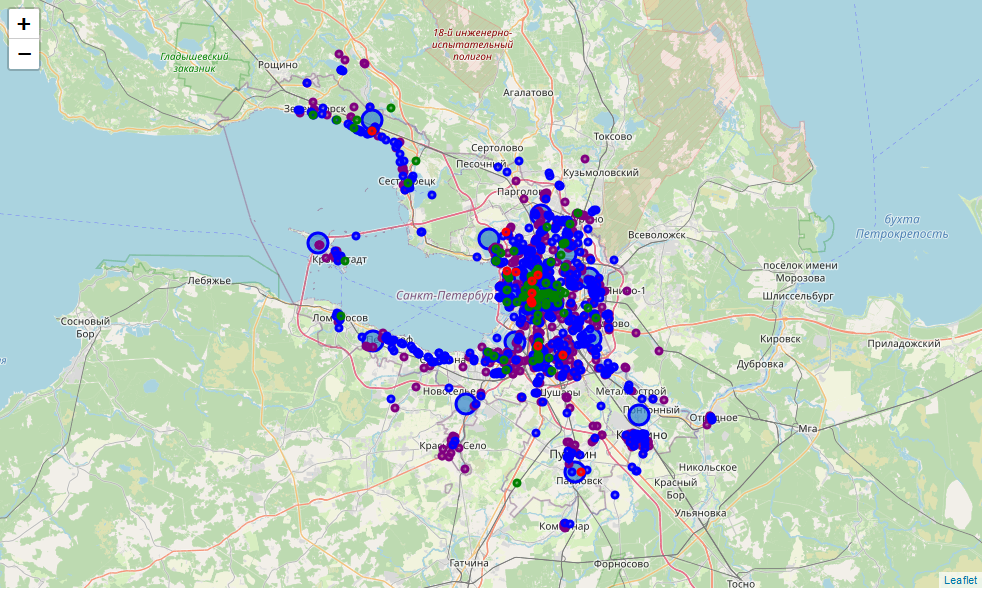

In [149]:
display(Image(filename='./img/venues_prices.PNG'))

### Now we create onehot table of all venues

In [65]:
spb_onehot = pd.get_dummies(spb_venues[['Venue Category']], 
                            prefix="", 
                            prefix_sep="")

spb_onehot['District'] = spb_venues['District'] 

fixed_columns = [spb_onehot.columns[-1]] + list(spb_onehot.columns[:-1])

spb_onehot = spb_onehot[fixed_columns]

spb_onehot.shape

(1443, 63)

In [66]:
# or mean()
spb_grouped = spb_onehot.groupby('District').sum().reset_index()
spb_grouped

District  American Restaurant  Asian Restaurant  BBQ Joint  \
0      Адмиралтейский                    1                 4          1   
1    Василеостровский                    0                 2          3   
2          Выборгский                    1                 1          1   
3         Калининский                    2                 1          3   
4           Кировский                    1                 2          0   
5          Колпинский                    0                 0          2   
6   Красногвардейский                    0                 3          5   
7      Красносельский                    0                 0          0   
8       Кронштадтский                    0                 0          0   
9           Курортный                    0                 1          2   
10         Московский                    0                 0          4   
11            Невский                    0                 0          3   
12      Петроградский                    0                 2          2   
13     Петродворцовый                    0                 0          2   
14         Приморский                    0                 0          2   
15         Пушкинский                    0                 0          0   
16        Фрунзенский                    1                 1          4   
17        Центральный                    1                 5          2   

    Bakery  Belgian Restaurant  Bistro  Breakfast Spot  Buffet  Burger Joint  \
0       24                   0       0               2       0             3   
1       18                   1       0               1       1             6   
2       36                   0       0               0       0             3   
3       23                   0       0               0       0             1   
4       18                   0       0               1       0             0   
5        4                   0       0               0       0             0   
6       20                   0       0               0       0             1   
7        7                   0       0               0       0             0   
8        5                   0       0               0       0             0   
9        4                   0       0               3       0             1   
10      22                   0       0               0       0             0   
11      15                   0       0               0       0             0   
12      23                   0       1               1       1             1   
13       1                   0       0               1       0             0   
14       0                   0       0               0       0             0   
15       2                   0       0               0       0             0   
16      16                   0       1               0       0             0   
17      22                   0       0               1       0             5   

    ...  Spanish Restaurant  Steakhouse  Sushi Restaurant  Taco Place  \
0   ...                   0           1                 0           0   
1   ...                   0           2                 2           1   
2   ...                   0           0                 3           0   
3   ...                   0           0                 6           0   
4   ...                   0           0                11           0   
5   ...                   0           0                 8           0   
6   ...                   0           0                 9           0   
7   ...                   0           0                 2           0   
8   ...                   0           0                 0           0   
9   ...                   0           2                 3           0   
10  ...                   1           2                 5           0   
11  ...                   0           0                 2           0   
12  ...                   0           3                 7           1   
13  ...                   0           0     

In [134]:
num_top_venues = 5

for hood in spb_grouped['District']:
    print("----"+hood+"----")
    
    temp = (spb_grouped[spb_grouped['District'] == hood]\
            .T.reset_index()
           )
    temp.columns = ['venue','num']
    temp = temp.iloc[1:]
    
    rating = temp.sort_values('num', 
                              ascending=False).reset_index(drop=True)
    
    print(rating.head(num_top_venues))
    print('\n')

----Адмиралтейский----
                  venue num
0                Bakery  24
1                  Café  18
2            Restaurant  14
3    Italian Restaurant   8
4  Caucasian Restaurant   5


----Василеостровский----
                venue num
0              Bakery  18
1                Café  15
2          Restaurant  11
3  Italian Restaurant   8
4           Gastropub   7


----Выборгский----
                 venue num
0               Bakery  36
1                 Café   9
2           Restaurant   8
3  Japanese Restaurant   4
4          Pizza Place   4


----Калининский----
                  venue num
0                Bakery  23
1                  Café  17
2            Restaurant  10
3  Fast Food Restaurant   9
4           Pizza Place   8


----Кировский----
                  venue num
0                Bakery  18
1      Sushi Restaurant  11
2           Pizza Place   8
3                  Café   8
4  Fast Food Restaurant   5


----Колпинский----
                  venue num
0               

### Create DataFrame with top10 venues for each district

In [136]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, 
                                                       indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = spb_grouped['District']

for ind in np.arange(spb_grouped.shape[0]):
    top10_for_dist = return_most_common_venues(spb_grouped.iloc[ind,:], 
                                               num_top_venues)
    district_venues_sorted.iloc[ind, 1:] = top10_for_dist

district_venues_sorted.head()

District 1st Most Common Venue 2nd Most Common Venue  \
0    Адмиралтейский                Bakery                  Café   
1  Василеостровский                Bakery                  Café   
2        Выборгский                Bakery                  Café   
3       Калининский                Bakery                  Café   
4         Кировский                Bakery      Sushi Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Restaurant    Italian Restaurant  Caucasian Restaurant   
1            Restaurant    Italian Restaurant             Gastropub   
2            Restaurant    Italian Restaurant   Japanese Restaurant   
3            Restaurant  Fast Food Restaurant           Pizza Place   
4           Pizza Place                  Café  Fast Food Restaurant   

         6th Most Common Venue        7th Most Common Venue  \
0  Eastern European Restaurant             Asian Restaurant   
1                 Burger Joint  Eastern European Restaurant   
2                  Pizza Place                 Burger Joint   
3    Middle Eastern Restaurant             Sushi Restaurant   
4                   Restaurant           Italian Restaurant   

         8th Most Common Venue        9th Most Common Venue  \
0          Japanese Restaurant                 Burger Joint   
1           Chinese Restaurant    Middle Eastern Restaurant   
2             Sushi Restaurant        Vietnamese Restaurant   
3                    Gastropub  Eastern European Restaurant   
4  Eastern European Restaurant                    Gastropub   

          10th Most Common Venue  
0  Vegetarian / Vegan Restaurant  
1  Vegetarian / Vegan Restaurant  
2           Caucasian Restaurant  
3             Italian Restaurant  
4               Asian Restaurant

### Convert column with venue price policy into string var for to_dummies() method

In [70]:
spb_venues = spb_venues.astype({'Price': 'str'})
price_range = ['* Low', 
               '** Average', 
               '*** High', 
               '**** Top']

for price_tag, i in zip(price_range, 
                        range(0, len(price_range))):
    
    spb_venues.loc[spb_venues.Price == str(i + 1), 
                   ['Price']] = price_tag
spb_venues.head()

District  District Latitude  District Longitude  \
0     Адмиралтейский          59.916824           30.297542   
1     Адмиралтейский          59.916824           30.297542   
2     Адмиралтейский          59.916824           30.297542   
3     Адмиралтейский          59.916824           30.297542   
4     Адмиралтейский          59.916824           30.297542   
...              ...                ...                 ...   
1438   Петроградский          59.967686           30.281660   
1439      Приморский          60.017715           30.185145   
1440      Пушкинский          59.696674           30.421276   
1441     Фрунзенский          59.869965           30.390788   
1442     Фрунзенский          59.869965           30.390788   

                      Venue ID                 Venue  Venue Latitude  \
0     58b979ab15fb437fcf856ba0  Булочная Ф. Вольчека       59.910548   
1     5b093891bf7dde002ccdd121              Günter’s       59.922112   
2     4e9eba6abe7b048b34948ac2             Щелкунчик       59.924010   
3     587c6e3375e1371297b40c7d  Булочная Ф. Вольчека       59.922326   
4     58524bbe7d66be0dde6a941c  Булочная Ф. Вольчека       59.916028   
...                        ...                   ...             ...   
1438  4c8bc9fccf3ea1433e08ef51         Casa del Мясо       59.943472   
1439  52b5a3ad498ea21d33cc43d0          Sergio Küche       60.027664   
1440  4d6507c7823ca35d0676fa88              Подворье       59.696194   
1441  58765adb01f077270491c3e0           #СтейкДавай       59.858072   
1442  574490f9498e6ad55900f752           #Стейкдавай       59.870773   

      Venue Longitude  Distance                   Venue Category     Price  
0           30.297582       698                           Bakery     * Low  
1           30.307945       826                    Hot Dog Joint     * Low  
2           30.293293       834                             Café     * Low  
3           30.307998       845                           Bakery     * Low  
4           30.314256       936                           Bakery     * Low  
...               ...       ...                              ...       ...  
1438        30.302820      2942                       Steakhouse  **** Top  
1439        30.230727      2766  Molecular Gastronomy Restaurant  **** Top  
1440        30.438276       956               Russian Restaurant  **** Top  
1441        30.388472      1330                       Steakhouse  **** Top  
1442        30.319677      3974                       Steakhouse  **** Top  

[1443 rows x 10 columns]

In [71]:
spb_venues.Price.value_counts()

* Low         698
** Average    643
*** High       90
**** Top       12
Name: Price, dtype: int64

### Create one hot venues encoding for all venues and then group it by District

In [72]:
spb_price_onehot = pd.get_dummies(spb_venues[['Price']],
                                  prefix="VP",
                                  prefix_sep=" ")

spb_price_onehot['District'] = spb_venues['District'] 

fixed_columns = ([spb_price_onehot.columns[-1]]
                 + list(spb_price_onehot.columns[:-1]))

spb_price_onehot = spb_price_onehot[fixed_columns]

spb_price_onehot.head()

District  VP * Low  VP ** Average  VP *** High  VP **** Top
0  Адмиралтейский         1              0            0            0
1  Адмиралтейский         1              0            0            0
2  Адмиралтейский         1              0            0            0
3  Адмиралтейский         1              0            0            0
4  Адмиралтейский         1              0            0            0

In [73]:
# or mean() if neccessary
spb_price_grouped = spb_price_onehot.groupby('District').sum().reset_index()
spb_price_grouped

District  VP * Low  VP ** Average  VP *** High  VP **** Top
0      Адмиралтейский        51             52            8            2
1    Василеостровский        52             65           12            1
2          Выборгский        58             33            3            0
3         Калининский        65             52            7            0
4           Кировский        45             22            4            0
5          Колпинский        57             32            0            0
6   Красногвардейский        46             47            1            0
7      Красносельский        30             21            0            0
8       Кронштадтский        18              5            1            0
9           Курортный        34             49            8            1
10         Московский        40             32            8            0
11            Невский        24             17            1            0
12      Петроградский        56             58           12            4
13     Петродворцовый        12             24            1            0
14         Приморский         0             13            3            1
15         Пушкинский        10             13            1            1
16        Фрунзенский        61             49            4            2
17        Центральный        39             59           16            0

### Add venues price data into main dataframe

In [74]:
spb_df = spb_df.merge(spb_price_grouped[['VP * Low',
                                         'VP ** Average',
                                         'VP *** High',
                                         'VP **** Top']], 
                      left_index=True, 
                      right_index=True)
spb_df

DNumber           District  Population  Square       Density   Latitude  \
0         1     Адмиралтейский      159795   13.82  11562.599609  59.916824   
1         2   Василеостровский      207482   21.47   9663.799805  59.941425   
2         3         Выборгский      522746  115.52   4525.200195  60.050449   
3         4        Калининский      529187   40.18  13170.400391  59.997684   
4         5          Кировский      336157   47.46   7083.000000  59.876392   
5         6         Колпинский      193839  102.25   1895.699951  59.775082   
6         7  Красногвардейский      356628   56.35   6328.799805  59.964458   
7         8     Красносельский      408026   90.49   4509.100098  59.790794   
8         9      Кронштадтский       44461   19.53   2276.500000  60.013058   
9        10          Курортный       79067  268.19    294.799988  60.181217   
10       11         Московский      352172   73.07   4819.700195  59.852177   
11       12            Невский      536137   60.66   8838.400391  59.881931   
12       13      Петроградский      128075   19.54   6554.500000  59.967686   
13       14     Петродворцовый      143823  107.08   1343.099976  59.877846   
14       15         Приморский      573024  109.90   5214.000000  60.017715   
15       16         Пушкинский      226336  240.09    942.700012  59.696674   
16       17        Фрунзенский      386537   37.52  10302.200195  59.869965   
17       18        Центральный      214572   17.77  12075.000000  59.930908   

    Longitude  Income     RentCost  FlatCostPerM  FCChange            R1  \
0   30.297542   81481  1408.800000      136000.0     0.205   2029.900654   
1   30.248045   71982  4684.600000      110000.0    -0.057   1675.697735   
2   30.328696   64784  1121.100000      117000.0     0.330   4310.003781   
3   30.396824   61920  1065.700000      110000.0     0.085   3417.388347   
4   30.257603   60380  1055.700000      109500.0     0.232   2148.209815   
5   30.595792   55949   315.500000       65500.0     0.006   5987.471280   
6   30.460398   59378  1011.600000       94200.0     0.135   3331.249484   
7   30.121823   55923  1436.200000      111000.0     0.164   8685.956935   
8   29.714374   51136  1412.876471      103900.0     0.572   8606.694318   
9   29.864878   62644   600.300000       74000.0    -0.209  16900.267268   
10  30.323073   73386  1363.100000      114300.0    -0.031   3332.074000   
11  30.464602   56042  1273.100000      106700.0     0.204   5011.788378   
12  30.281660   89752  1664.300000      193500.0     0.094   2859.419101   
13  29.866549   56741   814.400000       73300.0     0.049  11380.375866   
14  30.185145   65833  1296.300000      111200.0     0.087   3800.790577   
15  30.421276   58602  1193.700000       82200.0    -0.121   9180.696386   
16  30.390788   56098  1362.500000      127800.0     0.128   3038.144893   
17  30.361817   76728  2352.000000      176700.0     0.117   3251.033728   

              R2          R3            R4             R  VP * Low  \
0    2258.764952   6190.9924   2144.332803   4167.662601        51   
1    1273.243717   6460.9609   1474.470726   3967.715813        52   
2    2596.343076  19344.8704   3453.173428  11399.021914        58   
3    2858.177944   7614.4324   3137.783146   5376.107773        65   
4    3217.939763   8252.4516   2683.074789   5467.763195        45   
5    8161.002855  16455.0625   7074.237067  11764.649784        57   
6    2858.177944   9175.3225   3094.713714   6135.018107        46   
7    5668.454147  14188.4401   7177.205541  10682.822820        30   
8    5369.829404   6381.4209   6988.261861   6684.841381        18   
9    4612.457059  77925.8761  10756.362164  12000.000000        34   
10   3513.464855  11339.2249   3422.769427   7380.997164        40   
11   3980.508850   9679.6356   4496.148614   7087.892107        24   
12   1273.243717   6381.8116   2066.331409   4224.071505        56   
13  12735.046792  17466.1264  12057.711329  12000.000000        12   
14   43

### Add new cloumn with sum of all district venues and remove unnecessery ones

In [75]:
spb_df.drop(columns=['R1', 'R2', 
                     'R3', 'R4'], 
            inplace=True, 
            errors='ignore')

spb_df['Venues'] = (spb_df['VP * Low']
                    + spb_df['VP ** Average']
                    + spb_df['VP *** High']
                    + spb_df['VP **** Top'])
spb_df

DNumber           District  Population  Square       Density   Latitude  \
0         1     Адмиралтейский      159795   13.82  11562.599609  59.916824   
1         2   Василеостровский      207482   21.47   9663.799805  59.941425   
2         3         Выборгский      522746  115.52   4525.200195  60.050449   
3         4        Калининский      529187   40.18  13170.400391  59.997684   
4         5          Кировский      336157   47.46   7083.000000  59.876392   
5         6         Колпинский      193839  102.25   1895.699951  59.775082   
6         7  Красногвардейский      356628   56.35   6328.799805  59.964458   
7         8     Красносельский      408026   90.49   4509.100098  59.790794   
8         9      Кронштадтский       44461   19.53   2276.500000  60.013058   
9        10          Курортный       79067  268.19    294.799988  60.181217   
10       11         Московский      352172   73.07   4819.700195  59.852177   
11       12            Невский      536137   60.66   8838.400391  59.881931   
12       13      Петроградский      128075   19.54   6554.500000  59.967686   
13       14     Петродворцовый      143823  107.08   1343.099976  59.877846   
14       15         Приморский      573024  109.90   5214.000000  60.017715   
15       16         Пушкинский      226336  240.09    942.700012  59.696674   
16       17        Фрунзенский      386537   37.52  10302.200195  59.869965   
17       18        Центральный      214572   17.77  12075.000000  59.930908   

    Longitude  Income     RentCost  FlatCostPerM  FCChange             R  \
0   30.297542   81481  1408.800000      136000.0     0.205   4167.662601   
1   30.248045   71982  4684.600000      110000.0    -0.057   3967.715813   
2   30.328696   64784  1121.100000      117000.0     0.330  11399.021914   
3   30.396824   61920  1065.700000      110000.0     0.085   5376.107773   
4   30.257603   60380  1055.700000      109500.0     0.232   5467.763195   
5   30.595792   55949   315.500000       65500.0     0.006  11764.649784   
6   30.460398   59378  1011.600000       94200.0     0.135   6135.018107   
7   30.121823   55923  1436.200000      111000.0     0.164  10682.822820   
8   29.714374   51136  1412.876471      103900.0     0.572   6684.841381   
9   29.864878   62644   600.300000       74000.0    -0.209  12000.000000   
10  30.323073   73386  1363.100000      114300.0    -0.031   7380.997164   
11  30.464602   56042  1273.100000      106700.0     0.204   7087.892107   
12  30.281660   89752  1664.300000      193500.0     0.094   4224.071505   
13  29.866549   56741   814.400000       73300.0     0.049  12000.000000   
14  30.185145   65833  1296.300000      111200.0     0.087  11077.285566   
15  30.421276   58602  1193.700000       82200.0    -0.121  12000.000000   
16  30.390788   56098  1362.500000      127800.0     0.128   5341.777637   
17  30.361817   76728  2352.000000      176700.0     0.117   4821.339740   

    VP * Low  VP ** Average  VP *** High  VP **** Top  Venues  
0         51             52            8            2     113  
1         52             65           12            1     130  
2         58             33            3            0      94  
3         65             52            7            0     124  
4         45             22            4            0      71  
5         57             32            0            0      89  
6         46             47            1            0      94  
7         30             21            0            0      51  
8         18              5            1            0      24  
9         34             49            8            1      92  
10        40             32            8            0      80  
11        24             17            1            0      42  
12        56             58           12            4     130  
13        12             24            1            0      37  
14         0             13            3            1      17  
15        10             13      

In [76]:
# Creating backup of DF just in case...
spb_df_bkp = spb_df.copy()

### Let's browse through Dataframe and evaluate correlation between crucial data

In [77]:
correlation_df = spb_df[['Population', 
               'Square', 
               'Density', 
               'Income', 
               'RentCost', 
               'FlatCostPerM', 
               'VP * Low', 
               'VP ** Average', 
               'VP *** High', 
               'VP **** Top', 
               'Venues']].corr(method='pearson')

correlation_df.style.background_gradient(cmap='coolwarm')

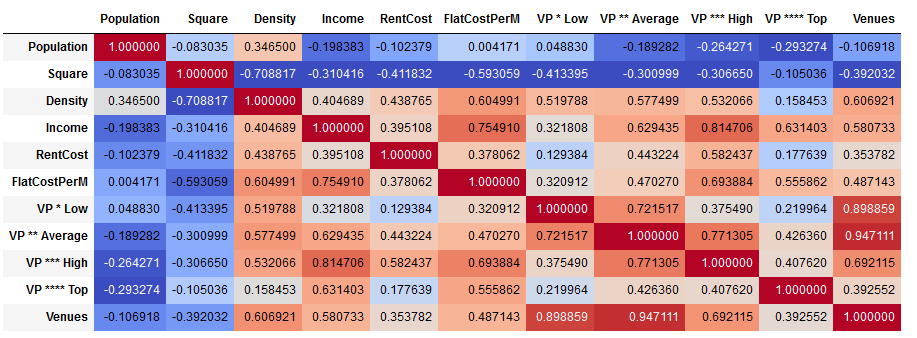

In [150]:
display(Image(filename='./img/corr_heatmap.PNG'))

### As we want to evaluate  parameters that correlate with expensive restaurants, we'll select only several features according to correlation matrix

In [78]:
features = ['Income', 'FlatCostPerM', 'VP ** Average', 'VP *** High']

### Browsing correlated param plots

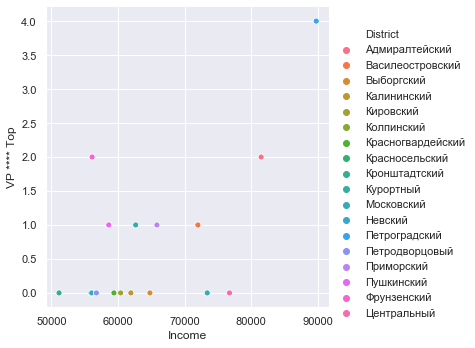

In [79]:
sns.set(style="darkgrid")
sns.relplot(x='Income', y='VP **** Top', hue='District', data=spb_df)

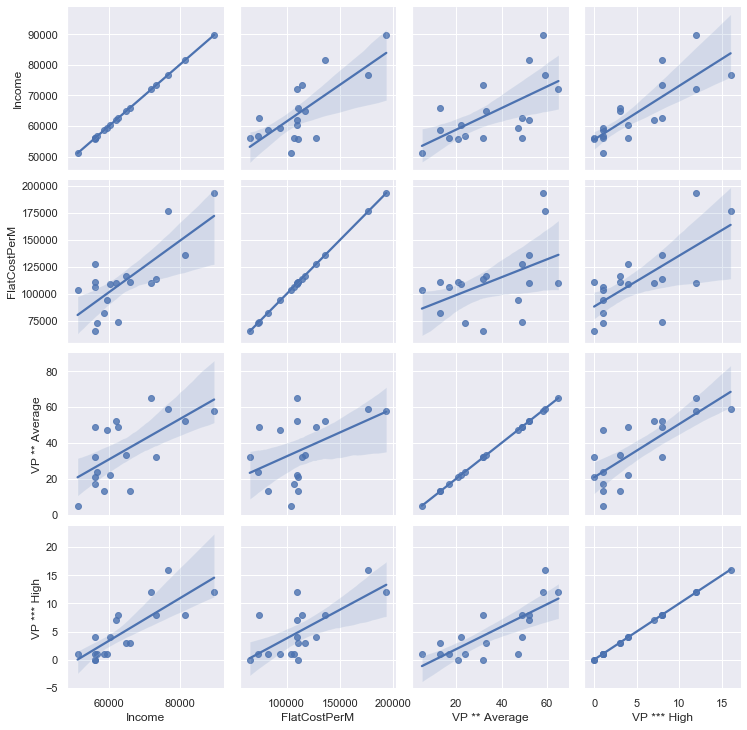

In [80]:
g = sns.PairGrid(spb_df[features])
g.map(sns.regplot)

### Now we preprocess data for better modelling

In [81]:
X = spb_df[features].values
X[0:5]

array([[8.1481e+04, 1.3600e+05, 5.2000e+01, 8.0000e+00],
       [7.1982e+04, 1.1000e+05, 6.5000e+01, 1.2000e+01],
       [6.4784e+04, 1.1700e+05, 3.3000e+01, 3.0000e+00],
       [6.1920e+04, 1.1000e+05, 5.2000e+01, 7.0000e+00],
       [6.0380e+04, 1.0950e+05, 2.2000e+01, 4.0000e+00]])

In [82]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.69750435,  0.75539045,  0.90606183,  0.64450339],
       [ 0.75484884, -0.06446746,  1.62967436,  1.50384124],
       [ 0.04053845,  0.15626352, -0.1515257 , -0.42966892],
       [-0.24367729, -0.06446746,  0.90606183,  0.42966892],
       [-0.3965028 , -0.08023396, -0.76381322, -0.21483446]])

### Let's find out best K-param for KMeans clustering process

In [83]:
metric_scores = []

k_min = 2
k_max = 10

for k in range(k_min, k_max):
    spb_clustering_df = X
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    db_score = davies_bouldin_score(X, kmeans.labels_)
    ch_score = calinski_harabasz_score(X, kmeans.labels_)
    s_score = silhouette_score(X, kmeans.labels_, metric='euclidean')
    
    metric_scores.append([k, db_score, ch_score, s_score])

metric_scores

[[2, 0.7133550239457775, 21.47863670352035, 0.49755437663593344],
 [3, 0.9843437910370563, 19.14930250194232, 0.32235763576109444],
 [4, 0.9553993509201002, 18.2286951214068, 0.31617697453492477],
 [5, 0.8795019028475262, 16.279506854081824, 0.2762016356220343],
 [6, 0.9080209563163125, 15.14332937954867, 0.2502131302128696],
 [7, 0.7384042041938189, 14.607769995757808, 0.2592375380559034],
 [8, 0.6916349103802848, 14.711234279662209, 0.23215197733952875],
 [9, 0.6093259826320557, 14.989430273076788, 0.19239956959703897]]

#### Hint!
1. db_score - lower means better cluster separation

2. ch_score - higher means better cluster definition

3. higher Silhouette Coefficient score relates to a model with better defined clusters

As we can see above, the better weighted score - k=2

In [84]:
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

### Now we add our cluster labels

In [85]:
if 'Cluster' in spb_df.columns:
    spb_df.drop(axis=1,
                columns='Cluster',
                inplace=True)

spb_df.insert(len(spb_df.columns), 'Cluster', kmeans.labels_)
spb_df

DNumber           District  Population  Square       Density   Latitude  \
0         1     Адмиралтейский      159795   13.82  11562.599609  59.916824   
1         2   Василеостровский      207482   21.47   9663.799805  59.941425   
2         3         Выборгский      522746  115.52   4525.200195  60.050449   
3         4        Калининский      529187   40.18  13170.400391  59.997684   
4         5          Кировский      336157   47.46   7083.000000  59.876392   
5         6         Колпинский      193839  102.25   1895.699951  59.775082   
6         7  Красногвардейский      356628   56.35   6328.799805  59.964458   
7         8     Красносельский      408026   90.49   4509.100098  59.790794   
8         9      Кронштадтский       44461   19.53   2276.500000  60.013058   
9        10          Курортный       79067  268.19    294.799988  60.181217   
10       11         Московский      352172   73.07   4819.700195  59.852177   
11       12            Невский      536137   60.66   8838.400391  59.881931   
12       13      Петроградский      128075   19.54   6554.500000  59.967686   
13       14     Петродворцовый      143823  107.08   1343.099976  59.877846   
14       15         Приморский      573024  109.90   5214.000000  60.017715   
15       16         Пушкинский      226336  240.09    942.700012  59.696674   
16       17        Фрунзенский      386537   37.52  10302.200195  59.869965   
17       18        Центральный      214572   17.77  12075.000000  59.930908   

    Longitude  Income     RentCost  FlatCostPerM  FCChange             R  \
0   30.297542   81481  1408.800000      136000.0     0.205   4167.662601   
1   30.248045   71982  4684.600000      110000.0    -0.057   3967.715813   
2   30.328696   64784  1121.100000      117000.0     0.330  11399.021914   
3   30.396824   61920  1065.700000      110000.0     0.085   5376.107773   
4   30.257603   60380  1055.700000      109500.0     0.232   5467.763195   
5   30.595792   55949   315.500000       65500.0     0.006  11764.649784   
6   30.460398   59378  1011.600000       94200.0     0.135   6135.018107   
7   30.121823   55923  1436.200000      111000.0     0.164  10682.822820   
8   29.714374   51136  1412.876471      103900.0     0.572   6684.841381   
9   29.864878   62644   600.300000       74000.0    -0.209  12000.000000   
10  30.323073   73386  1363.100000      114300.0    -0.031   7380.997164   
11  30.464602   56042  1273.100000      106700.0     0.204   7087.892107   
12  30.281660   89752  1664.300000      193500.0     0.094   4224.071505   
13  29.866549   56741   814.400000       73300.0     0.049  12000.000000   
14  30.185145   65833  1296.300000      111200.0     0.087  11077.285566   
15  30.421276   58602  1193.700000       82200.0    -0.121  12000.000000   
16  30.390788   56098  1362.500000      127800.0     0.128   5341.777637   
17  30.361817   76728  2352.000000      176700.0     0.117   4821.339740   

    VP * Low  VP ** Average  VP *** High  VP **** Top  Venues  Cluster  
0         51             52            8            2     113        0  
1         52             65           12            1     130        0  
2         58             33            3            0      94        1  
3         65             52            7            0     124        1  
4         45             22            4            0      71        1  
5         57             32            0            0      89        1  
6         46             47            1            0      94        1  
7         30             21            0            0      51        1  
8         18              5            1            0      24        1  
9         34             49            8            1      92        1  
10        40             32            8            0      80        1  
11        24             17            1            0      42        1  
12        56             58           12            4     130        0  
13        12             24        

In [131]:
short_view = ["DNumber", "District", "Population", 
              "Income", "RentCost", "FlatCostPerM",
              "VP * Low", "VP ** Average", "VP *** High", 
              "VP **** Top", "Venues", "Cluster"]


max_income_cluster = int(spb_df['Cluster']\
                         [spb_df['Income']\
                          == spb_df['Income'].max()]
                        )

result_df = (spb_df[short_view][spb_df['Cluster'] == max_income_cluster]\
             .sort_values('Income',
                          ascending=False).copy()
            )

### Let's put new clusters on map

In [137]:
map_clusters = folium.Map(location=[latitude, longitude], 
                          zoom_start=9)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(spb_df['Latitude'], 
                                  spb_df['Longitude'], 
                                  spb_df['District'], 
                                  spb_df['Cluster']):
    label = folium.Popup(str(transliterate(poi)) 
                         + ' from Cluster: '
                         + str(cluster)
                        )
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

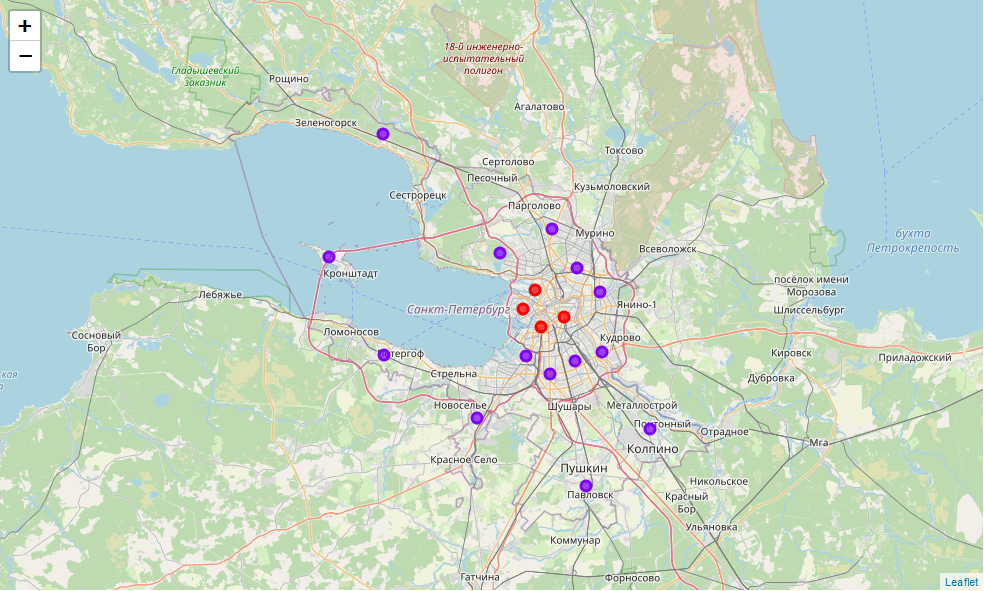

In [151]:
display(Image(filename='./img/dist_clustering.PNG'))

### Let's visualize venues from different clusters

We need to add cluster data into venues DataFrame

In [105]:
spb_venues['Cluster'] = 0
districts = spb_df.District.tolist()

for district in districts:
    district_mask = (spb_venues.District == district)
    cluster_num = spb_df.Cluster[spb_df.District == district].iloc[0]
    
    spb_venues.loc[district_mask, ['Cluster']] = cluster_num

spb_venues.head()

In [125]:
map_clusters = folium.Map(location=[latitude, longitude], 
                          zoom_start=10)
color_range = len(spb_venues.Cluster.unique())

x = np.arange(color_range)
ys = [i + x + (i*x)**2 for i in range(color_range)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, name, cluster in zip(spb_venues['Venue Latitude'], 
                                   spb_venues['Venue Longitude'],
                                   spb_venues['Venue'],
                                   spb_venues['Cluster']):
    label = folium.Popup(str(transliterate(name))
                         + ' from Cluster: '
                         + str(cluster)
                        )
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

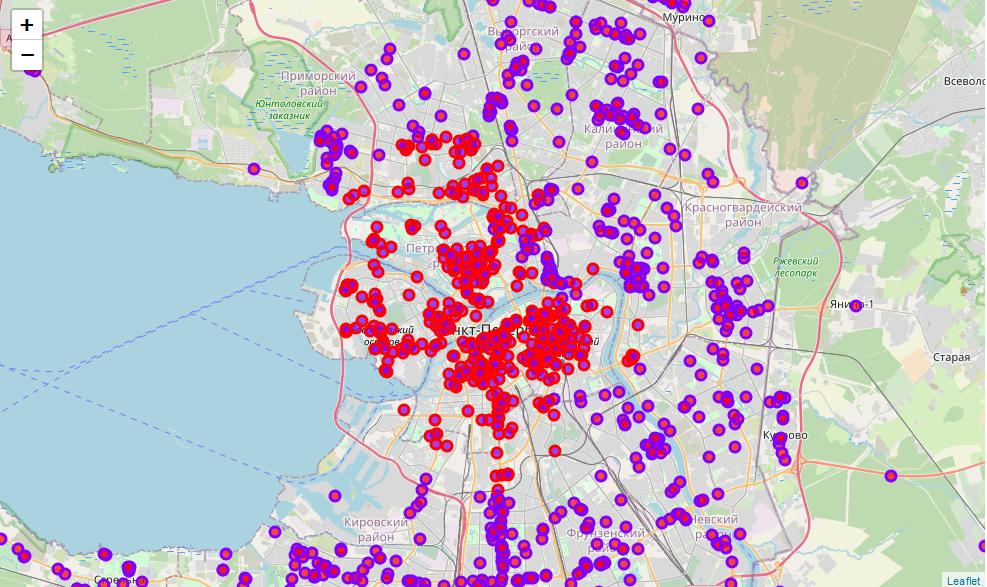

In [152]:
display(Image(filename='./img/ven_clustering.PNG'))

### Add clustering info to DF with top 10 food venues

In [88]:
if 'Cluster' in district_venues_sorted.columns:
    district_venues_sorted.drop(axis=1,
                                columns='Cluster',
                                inplace=True)

column_number = len(district_venues_sorted.columns)

district_venues_sorted.insert(column_number, 
                              'Cluster', 
                              kmeans.labels_)

### Let's browse Districts from target cluster

1. Sorting by number of venues with the top price category
2. Sorting results of the first sorting by average income

In [132]:
result_cluster_df = (result_df.sort_values('FlatCostPerM', 
                                          ascending=False)\
                     .sort_values('VP **** Top')
                    )
result_cluster_df

DNumber          District  Population  Income  RentCost  FlatCostPerM  \
17       18       Центральный      214572   76728    2352.0      176700.0   
1         2  Василеостровский      207482   71982    4684.6      110000.0   
0         1    Адмиралтейский      159795   81481    1408.8      136000.0   
12       13     Петроградский      128075   89752    1664.3      193500.0   

    VP * Low  VP ** Average  VP *** High  VP **** Top  Venues  Cluster  
17        39             59           16            0     114        0  
1         52             65           12            1     130        0  
0         51             52            8            2     113        0  
12        56             58           12            4     130        0

In [156]:
best_district = result_cluster_df.District.iloc[0]
print('The best match for the request is: '
      + f'{best_district} '
      + f'({transliterate(best_district)})'
     )

The best match for the request is: Центральный (Centralnyy)


### Here is best match for result in stats

In [92]:
spb_df[short_view][spb_df.District == best_district]

DNumber     District  Population  Income  RentCost  FlatCostPerM  \
17       18  Центральный      214572   76728    2352.0      176700.0   

    VP * Low  VP ** Average  VP *** High  VP **** Top  Venues  Cluster  
17        39             59           16            0     114        0

### We can also look through top 10 food venues in this District

In [93]:
district_venues_sorted[district_venues_sorted.District == best_district]

District 1st Most Common Venue 2nd Most Common Venue  \
17  Центральный                Bakery            Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
17    Italian Restaurant                  Café             Gastropub   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
17      Asian Restaurant          Burger Joint  Caucasian Restaurant   

          9th Most Common Venue 10th Most Common Venue  Cluster  
17  Eastern European Restaurant     Seafood Restaurant        0

### Finally, we can count top 30 venues to decide what kind of restaurant is or will be popular in this location

In [138]:
num_top_venues = 30

print(f"{best_district}")

venues_in_best_district = (spb_grouped[spb_grouped['District']\
                                       == best_district]\
                           .T.reset_index()
                          )

venues_in_best_district.columns = ['Venue','Num']

venues_in_best_district = venues_in_best_district.iloc[1:]

top30 = (venues_in_best_district.sort_values('Num', ascending=False)\
         .reset_index(drop=True).head(num_top_venues)
        )

top30

Центральный


Venue Num
0                          Bakery  22
1                      Restaurant  13
2              Italian Restaurant  12
3                            Café   7
4                       Gastropub   7
5                    Burger Joint   5
6                Asian Restaurant   5
7              Seafood Restaurant   4
8     Eastern European Restaurant   4
9            Caucasian Restaurant   4
10                    Pizza Place   3
11  Vegetarian / Vegan Restaurant   3
12     Modern European Restaurant   2
13                      BBQ Joint   2
14               Doner Restaurant   2
15              Korean Restaurant   2
16              Indian Restaurant   1
17                      Irish Pub   1
18            Japanese Restaurant   1
19            American Restaurant   1
20             Mexican Restaurant   1
21      Middle Eastern Restaurant   1
22               Greek Restaurant   1
23               Sushi Restaurant   1
24               Tapas Restaurant   1
25                  Pelmeni House   1
26             Israeli Restaurant   1
27              German Restaurant   1
28           Fast Food Restaurant   1
29                 Breakfast Spot   1

### There is a top 30 of the most popular venues of Saint-Petersburg

It's possible to make cross validation to determine specific venue type. The idea of this process is to find out what kind of venues are the most common in city and compare them with the list of more common venues in the district. Then we remove common district venues from the city top and the result will decribe the lack of common city venues in this specific district. 

### Cross validation of top10 district vs top10 city venues

In [139]:
dist_top10 = (venues_in_best_district.sort_values('Num', 
                                                  ascending=False)\
              .reset_index(drop=True).head(num_top_venues)\
              .Venue.head(10).tolist()
             )
dist_top10

['Bakery',
 'Restaurant',
 'Italian Restaurant',
 'Café',
 'Gastropub',
 'Burger Joint',
 'Asian Restaurant',
 'Seafood Restaurant',
 'Eastern European Restaurant',
 'Caucasian Restaurant']

In [140]:
city_top10 = (spb_venues["Venue Category"].value_counts()\
              .head(10).index.tolist()
             )
city_top10

['Bakery',
 'Café',
 'Restaurant',
 'Eastern European Restaurant',
 'Pizza Place',
 'Sushi Restaurant',
 'Italian Restaurant',
 'Fast Food Restaurant',
 'Middle Eastern Restaurant',
 'Gastropub']

### Finally, from the overall city popularity we can suggest that following venues could be popular in this district

In [141]:
new_venue_recommend = list(set(city_top10) - set(dist_top10))

print('According to the most popular vanues in city\n'
      + 'and existing venues in resulting District\n'
      + 'Venue suggestions for a new place are:\n'
      + f'{new_venue_recommend}')

According to the most popular vanues in city
and existing venues in resulting District
Venue suggestions for a new place are:
['Pizza Place', 'Sushi Restaurant', 'Middle Eastern Restaurant', 'Fast Food Restaurant']


## Results

### According to our results there is one district from four central ones that match criteria:

## District: Csentralny (Dnumber - 18) (Центральный)
1. There are over 200k population
2. Avg. m2 price is very high
3. High income rate
4. No competitive venues along the area